# GAMINet (Yang et al, 2021)

## Setup

In [1]:
#!nvidia-smi

In [2]:
!source ml-env/bin/activate

In [3]:
import wandb
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from gaminet.gaminet import GAMINet
from gaminet.gaminet.utils import local_visualize
from gaminet.gaminet.utils import global_visualize_density
from gaminet.gaminet.utils import global_visualize_wo_density
from gaminet.gaminet.utils import feature_importance_visualize
from gaminet.gaminet.utils import plot_regularization
from gaminet.gaminet.utils import plot_trajectory

### Setup multi-GPU training

In [4]:
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [5]:
wandb.login()
root_path ="./"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


## Data preprocessing and modelling methods

In [6]:
def data_splitter(X, y, end_of_training="1985-12-31", end_of_validation="1990-12-31"):
    # define start of training
    start_of_training = X.index.get_level_values(0).min()
   
    # define initial training and test window
    #train_window = pd.date_range(start=start_of_training, end=end_of_training, freq="M")
    #train_window = len(train_window)

    # slice to required size
    X_train = X.loc[pd.IndexSlice[start_of_training:end_of_training,], :]
    y_train = y.loc[pd.IndexSlice[start_of_training:end_of_training,]]
    X_valid = X.loc[pd.IndexSlice[end_of_training:end_of_validation,], :]
    y_valid = y.loc[pd.IndexSlice[end_of_training:end_of_validation,]]
    X_test = X.loc[pd.IndexSlice[end_of_validation:,], :]
    y_test = y.loc[pd.IndexSlice[end_of_validation:,]]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    #pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    #label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def mse(label, pred, scaler):
    return mean_squared_error(label, pred)

def mae(label, pred, scaler):
    return mean_absolute_error(label, pred)

def load_regression_data(pickle=False, feature_selector=[], subsample=False):
    # get and prepare data
    if pickle:
      data = pd.read_pickle(root_path + 'prev/data/firm_data_processed_wo_target.pkl')
    else:
      dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
    if subsample:
       data = pd.read_csv(root_path + 'data/subsample_processed_scaled.csv', index_col=["date","permno"],
                           parse_dates=['date'], date_parser=dateparse, skipinitialspace=True)
    else:
        data = pd.read_csv(root_path + 'data/data_processed_scaled.csv', index_col=["date","permno"],
                           parse_dates=['date'], date_parser=dateparse, skipinitialspace=True)
    #data = pd.read_csv(root_path + 'data_processed_scaled.csv')
    
    if len(feature_selector) > 0:
      data = data.loc[:,feature_selector]

    # scale target
    scaler = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    data['TARGET'] = scaler.fit_transform(target)
    
    # isolate target from feature space
    x = data.iloc[:,:-1]
    y = data.TARGET

    task_type = "Regression"
    meta_info = {x.columns[i]:{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})
    #xx = pd.DataFrame(np.zeros((x.shape[0], x.shape[1]), dtype=np.float32))
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = scaler
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            #x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx
    train_x, test_x, _, train_y, test_y, _ = data_splitter(x, y)
    train_x, test_x  = train_x.to_numpy(), test_x.to_numpy()
    train_y, test_y = train_y.to_numpy().reshape(-1,1), test_y.to_numpy().reshape(-1,1)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy), metric_wrapper(mse, sy), metric_wrapper(mae,sy)

## Feature selection 

In [7]:
## best features used by freyberger et al:
#features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 'roc', 'stock','suv', 'total_vol','TARGET']

### Feature selection by RF
(Markus B.)

In [8]:
## best features found by random forrest reg
#features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

### Features selected by AE

In [9]:
#features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']

In [10]:
# load preselected data
#train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = load_regression_data("crsp")

In [11]:
#train_x.shape

### All Data - Distributed training

In [12]:
# load preselected data
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = load_regression_data(subsample=True)

In [13]:
test_x.shape

(13538, 67)

2022-08-16 18:54:01.196582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 18:54:02.273691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30962 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2022-08-16 18:54:02.274647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30981 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.75382, val loss: 0.79318
Main effects training epoch: 6, train loss: 0.74501, val loss: 0.78602
Model is being saved
Main effects training epoch: 11, train loss: 0.74202, val loss: 0.78343
Main effects training epoch: 16, train loss: 0.73931, val loss: 0.78307
Model is being saved
Main effects training epoch: 21, train loss: 0.73772, val loss: 0.78146
Main effects training epoch: 26, train loss: 0.73482, val loss: 0.78060
Model is being saved
Main effects training epoch: 31, train loss: 0.73344, val loss: 0.78062
Main effects training epoch: 36, train loss: 0.73114, val loss: 0.77769
Model is being saved
Main effects training epoch: 41, train loss: 0.72917, val loss: 0.77681
Main effects training epoch: 46, train loss: 0.72770, val loss: 0.77617
Model is being saved
Main effects training epoch: 51, train loss: 0.72651, v

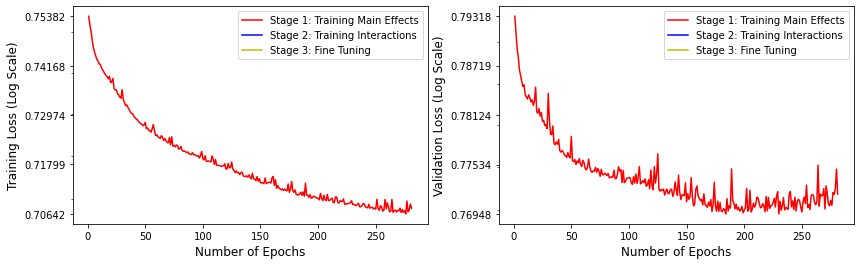

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/pfs/data5/home/kit/stud/uvnyg/gaminet/gaminet/utils.py:111: RuntimeWarning: All-NaN axis encountered
  ax2.set_yticks((10 ** np.linspace(np.log10(np.nanmin(inter_loss)), np.log10(np.nanmax(inter_loss)), 5)).round(5))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: cannot convert float NaN to integer

<Figure size 1008x288 with 2 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: cannot convert float NaN to integer

In [14]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

#with strategy.scope():
model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[40] * 4, subnet_arch=[40] * 4, #*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=1000, interaction_epochs=1000, tuning_epochs=500, #ep=5000
        lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
        heredity=True, loss_threshold=0.01, reg_clarity=0.1,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')# , strategy=strategy)

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

#wandb.log_artifact(model)

#wandb.log({
           #"maineffect train loss" : model.err_train_main_effect_training [-1],
           #"maineffect val loss" : model.err_val_main_effect_training[-1],
           #"interaction train loss" : model.err_train_interaction_training[-1],
           #"interaction val loss" : model.err_val_interaction_training[-1],
           #"Fine tuning train loss" : model.err_train_tuning[-1],
           #"Fine tuning val loss" : model.err_val_tuning[-1]
#})

data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="78_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="78_regu", save_png=True, save_eps=True)

In [15]:
prev_model = pd.read_pickle('./artifacts/current_model.pickle')

In [38]:
# this was an attempt to see the features ranked by importance...
idx = prev_model['active_main_effect_index']
feature_dict = list(meta_info.keys())
print("Main effect importance :", feature_dict[idx])

TypeError: only integer scalar arrays can be converted to a scalar index

## Save model for later use
[https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model]

In [ ]:
#print(Out)

In [ ]:
filepath='./models/'

tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

## Final model evaluation and interpretability

In [ ]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_rmse = np.hstack([np.round(get_rmse(train_y, pred_train),5),
                      np.round(get_rmse(test_y, pred_test),5)])
gaminet_mse = np.hstack([np.round(get_mse(train_y, pred_train),5),
                      np.round(get_mse(test_y, pred_test),5)])
gaminet_mae = np.hstack([np.round(get_mae(train_y, pred_train),5),
                      np.round(get_mae(test_y, pred_test),5)])

wandb.log({"rmse_train" : gaminet_rmse[0], "rmse_test" : gaminet_rmse[1],
           "mse_train" : gaminet_mse[0], "mse_test" : gaminet_mse[1],
           "mae_train" : gaminet_mae[0], "mae_test" : gaminet_mae[1]
           })
wandb.finish()
print(gaminet_mae)

In [ ]:
# Plot global explanations
data_dict_global = model.global_explain(save_dict=True, folder=folder, name="explain_global")
global_visualize_density(data_dict_global, folder=folder, name="explain_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

In [ ]:
# feature importance plot
feature_importance_visualize(data_dict_global, save_png=True)

In [ ]:
# local explanations
data_dict_local = model.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)